In [1]:
from naginterfaces.library import opt
from naginterfaces.library import rand
import numpy as np
from naginterfaces.base import utils

# Model-based derivative free optimization

We assume that the problems are of the form 
$$
\begin{equation*} 
\min_{x\in \mathbb{R}^n}{f(x)} 
\end{equation*}
$$
where $f$ is a nonlinear smooth objective function which might be also
- a black box in which the derivatives are unknown,
- expensive to evaluate,
- potentially noisy

Such problems are best tackled by DFO solvers. It should be emphasized that whenever the derivatives are available and are easy to compute, a derivative-based method should be preferred. 

There are several families of DFO algorithm, we will focus on model-based methods. They rely on quadratic models that match the value of the objective function $f$ on a set of interpolation points and on a trust region method which monitors a region in which the model is deemed accurate and thus ensures the convergence. A brief description of such an algorithm can be stated as follows:

- Initialization
    * Choose a first iterate and an initial trust region around it
    * Choose a set of interpolation points inside the trust region
    * Build a quadratic interpolation model inside the trust region
- Loop until convergence is reached
    * Minimize the model in the trust region
    * Evaluate the objective on the new point
    * If the model predicted correctly the decrease of the objective:
         - replace a far away interpolation point by the new point
         - move the trust region around the new point
    * Otherwise
         - either replace some interpolation points if their geometry is not good
         - or shrink the trust region

The following animation shows 2 iterations of a model-based DFO algorithm

In [2]:
import io
import base64
from IPython.display import HTML
video = io.open('animation.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

## DFO vs a derivative-based solver using finite difference estimations for the gradient 

DFO should use a bit less function evaluations and be much more robust with regard to noise. Let's illustrate these points on four functions from the CUTEst test set:
- Rosenbrock
- Arwhead
- Genhumps
- Dqdrtic

We chose the number of variables $n$ to be $10$ for all the problems. 
At their respective minima, all these functions are $0.0$.

Initialize the RNG, the user data to record the solver progression and define the objective callback:

In [3]:
# initialize the NAG random number generator
seed = [42]
genid = 1
statecomm = rand.init_repeat(genid, seed)

In [4]:
class usr_data:
    def __init__(self, statecomm=None):
        self.fun = 'rosen'
        self.nf = 0
        self.noiselev = 0.0
        self.statecomm = statecomm

In [5]:
def objfun(x, data):
    n = len(x)
    data.nf += 1
    if data.fun == 'rosen':
        obj = sum((1-x[:-1])**2 + 100*(x[1:]-x[:-1]**2)**2)
    elif data.fun == 'arwhead':
        obj = 0.0
        for i in range(n-1):
            obj += -4.0*x[i] + 3.0 + (x[i]**2 + x[n-1]**2)**2
    elif data.fun == 'genhumps':
        obj = 0.0
        for i in range(n-1):
            obj += np.sin(2.0*x[i])**2 * np.sin(2.0*x[i+1])**2 + 0.05*(x[i]**2+x[i+1]**2)
    elif data.fun == 'dqdrtic':
        obj = 0.0
        for i in range(n-2):
            obj += 100.0*x[i+1]**2 + 100*x[i+2]**2 + x[i]**2
            
    if data.noiselev != 0.0:
        noise = rand.dist_uniform(1,-data.noiselev, data.noiselev, data.statecomm)
        obj += noise[0]
        
    return obj

### No random noise in the function evaluations

First, solve these 4 problems without noise with the derivative based solver bounds_quasi_func_easy:

In [6]:
data = usr_data()
ibound = 1
n = 10
x = [0.0]*n
bigbnd = 1.0e20
bl = [-bigbnd]*n
bu = [bigbnd]*n

# Solve Rosenbrock
sln = opt.bounds_quasi_func_easy(ibound, objfun, bl, bu, x, data=data)
print('No noise, derivative based solver')
print('---------------------------------')
print('Rosenbrock:')
print('Final objective value', sln.f)
print('objective evaluations', data.nf)

# Solve Arwhead
data = usr_data()
data.fun = 'arwhead'
x = [0.0]*n
sln = opt.bounds_quasi_func_easy(ibound, objfun, bl, bu, x, data=data)
print()
print('Arwhead:')
print('Final objective value', sln.f)
print('objective evaluations', data.nf)

# Solve Genhumps
data = usr_data()
data.fun = 'genhumps'
x = [0.0]*n
sln = opt.bounds_quasi_func_easy(ibound, objfun, bl, bu, x, data=data)
print()
print('Genhumps:')
print('Final objective value', sln.f)
print('objective evaluations', data.nf)

# Solve Genhumps
data = usr_data()
data.fun = 'dqdrtic'
x = [0.0]*n
sln = opt.bounds_quasi_func_easy(ibound, objfun, bl, bu, x, data=data)
print()
print('dqdrtic:')
print('Final objective value', sln.f)
print('objective evaluations', data.nf)


No noise, derivative based solver
---------------------------------
Rosenbrock:
Final objective value 2.279587500118408e-16
objective evaluations 717

Arwhead:
Final objective value 0.0
objective evaluations 204

Genhumps:
Final objective value 0.0
objective evaluations 58

dqdrtic:
Final objective value 0.0
objective evaluations 55


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: NagAlgorithmicWarning: (NAG Python function naginterfaces.base.opt.bounds_quasi_func_easy, code 5:5,1)
** It is probable that a local minimum has been found,
** but it cannot be guaranteed.


Without noise, the solver correctly converges to the minimum. A warning is raised for the Arwhead problem but the final value is still correct.

Now let's do the same thing with the DFO solver bounds_bobyqa_func:

In [7]:
x = [0.0]*n
npt = 2*n + 1
rhobeg = 0.2
rhoend = 1.0e-06
maxcal = 1000

# Solve Rosenbrock
data = usr_data()
sln  = opt.bounds_bobyqa_func(objfun, npt, x, bl, bu, rhobeg, rhoend, maxcal, None, data)
print('No noise, derivative free solver')
print('--------------------------------')
print('Rosenbrock:')
print('Final objective value', sln.f)
print('Objective evaluations', data.nf)

# Solve arwhead problem
data = usr_data()
x = [0.0]*n
data.fun = 'arwhead'
sln  = opt.bounds_bobyqa_func(objfun, npt, x, bl, bu, rhobeg, rhoend, maxcal, None, data)
print()
print('Arwhead:')
print('Final objective value', sln.f)
print('Objective evaluations', data.nf)

# Solve Genhumps problem
data = usr_data()
x = [0.0]*n
data.fun = 'genhumps'
sln  = opt.bounds_bobyqa_func(objfun, npt, x, bl, bu, rhobeg, rhoend, maxcal, None, data)
print()
print('Genhumps:')
print('Final objective value', sln.f)
print('Objective evaluations', data.nf)

# Solve dqdrtic
data = usr_data()
x = [0.0]*n
data.fun = 'dqdrtic'
sln  = opt.bounds_bobyqa_func(objfun, npt, x, bl, bu, rhobeg, rhoend, maxcal, None, data)
print()
print('Dqdrtic:')
print('Final objective value', sln.f)
print('Objective evaluations', data.nf)

No noise, derivative free solver
--------------------------------
Rosenbrock:
Final objective value 2.969663108787601e-11
Objective evaluations 765

Arwhead:
Final objective value 3.964606420936434e-13
Objective evaluations 181

Genhumps:
Final objective value 0.0
Objective evaluations 34

Dqdrtic:
Final objective value 0.0
Objective evaluations 34


The DFO solver also correctly correctly converges, but generally requires less function evaluations. 

The only exception is the problem Rosenbrock. This function is especially difficult to minimize when no derivative information is available because of its geometry. This can easily be seen on the 2-dimension version:

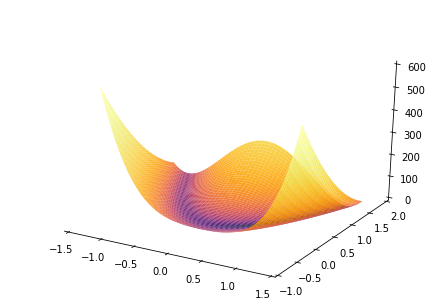

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm


def grid_rosen(X, Y):
    return (np.ones(X.shape) - X)**2 + 100*(Y - X**2)**2

fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlim3d(-1.5, 1.5)
ax.set_ylim3d(-1, 2)
ax.set_zlim3d(0, 600)
# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] = (1, 1, 1, 0)
ax.yaxis._axinfo["grid"]['color'] = (1, 1, 1, 0)
ax.zaxis._axinfo["grid"]['color'] = (1, 1, 1, 0)

x = np.linspace(-1.45, 1.45, 500)
y = np.linspace(-0.25, 1.5, 500)
X, Y = np.meshgrid(x, y)
Z = grid_rosen(X, Y)

a = ax.plot_surface(X, Y, Z, cmap=cm.inferno, norm=LogNorm(), alpha=0.9)
plt.show()

Rosenbrock is a very flat curved valley. Without derivatives, the solver has to constantly readjust its model to find the correct direction.

### Minimization with some uniform noise added to the function evaluation

We now try to solve the same problems, but each time a function evaluation is requested, a random value chosen uniformely in $[-10^{-08}, 10^{-08}]$ is added.

The deivative-based solver gives: 

In [9]:
# Solve Rosenbrock
data = usr_data(statecomm)
data.noiselev = 1.0e-08
x = [0.0]*n
print('Noise level', data.noiselev,'derivative based solver')
print('-----------------------------------------')
print('Rosenbrock:')
try:
    sln = opt.bounds_quasi_func_easy(ibound, objfun, bl, bu, x, data=data)
    print('Final objective value', sln.f)
    print('objective evaluations', data.nf)
except utils.NagValueError as e:
    if e.errno == 2:
        print('Maximum number of evaluations exceeded:', 400*n)
    else:
        print('error number not expected: ', e.errno)

# Solve Arwhead
data = usr_data(statecomm)
data.fun = 'arwhead'
data.noiselev = 1.0e-08
x = [0.0]*n
print()
print('Arwhead:')
try:
    sln = opt.bounds_quasi_func_easy(ibound, objfun, bl, bu, x, data=data)
    print('Final objective value', sln.f)
    print('objective evaluations', data.nf)
except utils.NagValueError as e:
    if e.errno == 2:
        print('Maximum number of evaluations exceeded:', 400*n)
    else:
        print('error number not expected: ', e.errno)
        
# Solve Genhumps
data = usr_data(statecomm)
data.fun = 'genhumps'
data.noiselev = 1.0e-08
x = [0.0]*n
print()
print('Genhumps:')
try:
    sln = opt.bounds_quasi_func_easy(ibound, objfun, bl, bu, x, data=data)
    print('Final objective value', sln.f)
    print('objective evaluations', data.nf)
except utils.NagValueError as e:
    if e.errno == 2:
        print('Maximum number of evaluations exceeded:', 400*n)
    else:
        print('error number not expected: ', e.errno)
        
# Solve Dqdrtic
data = usr_data(statecomm)
data.fun = 'dqdrtic'
data.noiselev = 1.0e-08
x = [0.0]*n
print()
print('Dqdrtic:')
try:
    sln = opt.bounds_quasi_func_easy(ibound, objfun, bl, bu, x, data=data)
    print('Final objective value', sln.f)
    print('objective evaluations', data.nf)
except utils.NagValueError as e:
    if e.errno == 2:
        print('Maximum number of evaluations exceeded:', 400*n)
    else:
        print('error number not expected: ', e.errno)

Noise level 1e-08 derivative based solver
-----------------------------------------
Rosenbrock:
Maximum number of evaluations exceeded: 4000

Arwhead:
Final objective value 0.02311674650122442
objective evaluations 1596

Genhumps:
Final objective value -9.846895173933805e-09
objective evaluations 647

Dqdrtic:
Final objective value -9.740606040194222e-09
objective evaluations 462


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: NagAlgorithmicWarning: (NAG Python function naginterfaces.base.opt.bounds_quasi_func_easy, code 3:3,1)
** The conditions for a minimum have not all been met but
** a lower point could not be found and the algorithm has failed.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: NagAlgorithmicWarning: (NAG Python function naginterfaces.base.opt.bounds_quasi_func_easy, code 3:3,1)
** The conditions for a minimum have not all been met but
** a lower point could not be found and the algorithm has failed.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: NagAlgorithmicWarning: (NAG Python function naginterfaces.base.opt.bounds_quasi_func_easy, code 3:3,1)
** The conditions for a minimum have not all been met but
** a lower point could not be found and the algorithm has failed.


With even a small amount of noise added, the solver now either doesn't converge or requires a much higher number of function evaluations.

The same experiment with the DFO solver gives:

In [11]:
# Solve Rosenbrock
data = usr_data(statecomm)
data.noiselev = 1.0e-08
x = [0.0]*n
sln  = opt.bounds_bobyqa_func(objfun, npt, x, bl, bu, rhobeg, rhoend, maxcal, None, data)
print('No noise, derivive based solver')
print('-------------------------------')
print('Rosenbrock:')
print('Final objective value', sln.f)
print('Objective evaluations', data.nf)

# Solve arwhead problem
data = usr_data(statecomm)
data.noiselev = 1.0e-08
x = [0.0]*n
data.fun = 'arwhead'
sln  = opt.bounds_bobyqa_func(objfun, npt, x, bl, bu, rhobeg, rhoend, maxcal, None, data)
print()
print('Arwhead:')
print('Final objective value', sln.f)
print('Objective evaluations', data.nf)

# Solve Genhumps problem
data = usr_data(statecomm)
data.noiselev = 1.0e-08
x = [0.0]*n
data.fun = 'genhumps'
sln  = opt.bounds_bobyqa_func(objfun, npt, x, bl, bu, rhobeg, rhoend, maxcal, None, data)
print()
print('Genhumps:')
print('Final objective value', sln.f)
print('Objective evaluations', data.nf)

# Solve dqdrtic
data = usr_data(statecomm)
data.noiselev = 1.0e-08
x = [0.0]*n
data.fun = 'dqdrtic'
sln  = opt.bounds_bobyqa_func(objfun, npt, x, bl, bu, rhobeg, rhoend, maxcal, None, data)
print()
print('Dqdrtic:')
print('Final objective value', sln.f)
print('Objective evaluations', data.nf)

No noise, derivive based solver
-------------------------------
Rosenbrock:
Final objective value 5.75994379349797e-07
Objective evaluations 719

Arwhead:
Final objective value 7.616405383472782e-08
Objective evaluations 175

Genhumps:
Final objective value -6.677712927384487e-09
Objective evaluations 89

Dqdrtic:
Final objective value -9.322618923437682e-09
Objective evaluations 71


The solver still converges to a function value within the noise range for only a small cost in term of number of function evaluations